# Case Study - NewYork Airbnb Price


## Google Drive 연동

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## JAVA 설치

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

## Spark 설치

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/2023/멀티캠퍼스/spark
!cp -r spark-3.1.1-bin-hadoop2.7.tgz /content
%cd /content/
!tar xf spark-3.1.1-bin-hadoop2.7.tgz > /dev/null

/content/drive/MyDrive/Colab Notebooks/2023/멀티캠퍼스/spark
/content


## 환경 세팅

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

## PySpark 설치

In [5]:
!pip install -q pyspark==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 13.9 MB/s eta 0:00:00


## 필요 라이브러리 불러오기
- 머신러닝 기본코드 작성

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, IntegerType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import FMRegressor

- Feature Engineering
  + VectorAssembler는 여러 특징 열을 단일 벡터 열로 조립하는 데 사용됩니다.
  + StringIndexer는 범주형 변수를 숫자 값으로 변환하는 데 사용됩니다.
  + OneHotEncoder는 범주형 변수를 원핫 인코딩하는 데 사용됩니다.
  + MinMaxScaler는 특징값을 특정 범위(일반적으로 [0, 1])로 스케일링합니다.

- Build regression models 는 모두 다양한 회귀 작업에 사용할 수 있는 서로 다른 회귀 모델임
  + LinearRegression
  + DecisionTreeRegressor
  + RandomForestRegressor
- 파이프라인은 일련의 데이터 변환 및 모델링 단계를 정의하는 데 사용됩니다. 일반적으로 Feature Engineering, Model Training 및 Model Evaluation 단계가 포함됨

- `TrainValidationSplit`는 하이퍼파라미터 튜닝 및 모델 선택에 사용되는 학습 세트와 유효성 검사 세트로 데이터를 분할하는 데 사용됨

- `RegressionEvaluator`는 RMSE, MAE 등과 같은 메트릭을 사용하여 회귀 모델의 성능을 평가하는 데 사용

- 마지막으로 파이프라인을 데이터에 맞추고 모델 선택 프로세스를 수행하는데, 여기에는 일반적으로 특정 회귀 작업에 가장 적합한 모델을 찾기 위해 다양한 모델과 하이퍼파라미터를 시도하는 것이 포함됩니다.


## 데이터 불러오기
- 데이터는 `Airbnb` 데이터셋이며, 출처는 아래와 같음.
  + 출처 : https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

In [7]:
sc = SparkSession.builder.appName('mulCamp28').config('spark.ui.port', '4050').getOrCreate()
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2023/멀티캠퍼스/spark/머신러닝/data/'
df = sc.read.csv(DATA_PATH + "airbnb.csv", header=True)
df.show(3)

+----+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|     John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845| Jennifer|          Manhattan|      M

- 데이터 확인

In [8]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



In [9]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'string')]

## 데이터 가공 및 변환

### 주요 컬럼 추출

In [10]:
df2 = df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', \
               'minimum_nights','number_of_reviews', 'last_review', 'reviews_per_month', \
               'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude')

### 데이터 형변환
- last_review 컬럼을 문자열에서 날짜로 변환한다.

In [11]:
df2 = df2.withColumn("last_review", to_date(df2.last_review, 'yyyy-MM-dd'))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377|
|          Manhattan|       Harlem|   Private room|  150|   

In [12]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'date'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string')]

- last_review의 열에서 가장 마지막 리뷰 날짜 값을 반환

In [13]:
max_date = df2.select(max("last_review")).collect()
max_date[0][0]

datetime.date(2019, 7, 8)

In [14]:
# DataFrame을 SQL에서 사용할 수 있도록 변환
df2.createOrReplaceTempView("myTable")
result = sc.sql("SELECT MAX(last_review) FROM myTable")
result.show()

+----------------+
|max(last_review)|
+----------------+
|      2019-07-08|
+----------------+



In [15]:
lit(max_date[0][0])

Column<'DATE '2019-07-08''>

- PySpark lit 함수는 Literal 값을 생성하는 데 사용됩니다.

In [16]:
datediff(lit(max_date[0][0]),lit(max_date[0][0]))

Column<'datediff(DATE '2019-07-08', DATE '2019-07-08')'>

- 제공한 코드는 두 개의 lit 함수와 max_date 값을 사용하여 두 개의 동일한 날짜 값 사이의 일수 차이를 계산하는 datediff 함수를 사용함
- 이 원리를 사용하여 마지막 리뷰가 업데이트된 날로부터 며칠이 지났는지 계산할 수 있습니다. 이 열을 'diff_in_days'라고 부를 수 있음.

In [17]:
df2 = df2.withColumn("diff_in_days", datediff(lit(max_date[0][0]), col("last_review")))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|         262|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377|         

### 인코딩 변환
- diff_in_days 컬럼 값을 범주형 변수로 인코딩


In [18]:
def date_replacement(date):
    if date is None:
        return "never"
    elif date <=3:
        return "three_days_ago"
    elif date <= 7:
        return "last_week_ago"
    elif date <= 30:
        return "last_month_ago"
    elif date <= 183:
        return "half_year_ago"
    elif date <= 365:
        return "one_year_ago"
    elif date <= 1825:
        return "5_years_ago"
    else:
        return "never"

- date_replacement(date) : 단일 인자인 날짜를 받는 Python 함수이다. 이 함수는 특정 조건에 따라 날짜의 차이를 나타내는 숫자 값(날짜)을 특정 문자열 레이블에 매핑하는 데 사용된다. 조건은 일의 차이를 다양한 시간 간격으로 분류하는 데 사용된다.

In [19]:
convertUDF = udf(lambda z: date_replacement(z), StringType())

df2 = df2.withColumn("diff_in_days", convertUDF(df2.diff_in_days))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

- 사용자 정의함수 `date_replacement` 파이썬 함수를 래핑하는 파이스파크 UDF(사용자 정의 함수) 이다. 이 함수는 UDF가 StringType 타입의 인수를 받도록 지정한다.
- `df2 = df2.withColumn("diff_in_days", convertUDF(df2.diff_in_days))`는 데이터프레임 df2의 "diff_in_days" 컬럼에 UDF를 적용하고 date_replacement 함수에 의해 생성된 레이블이 포함된 "diff_in_days"라는 새 열을 생성합니다.

### 문자열 변환
- 모든 문자열 유형 열을 정수 및 부동 소수점으로 타입 변환하기

In [20]:
df2 = df2.withColumn("price", df2["price"].cast(IntegerType()))
df2 = df2.withColumn("minimum_nights", df2["minimum_nights"].cast(IntegerType()))
df2 = df2.withColumn("number_of_reviews", df2["number_of_reviews"].cast(IntegerType()))
df2 = df2.withColumn("reviews_per_month", df2["reviews_per_month"].cast(FloatType()))
df2 = df2.withColumn("calculated_host_listings_count", df2["calculated_host_listings_count"].cast(IntegerType()))
df2 = df2.withColumn("availability_365", df2["availability_365"].cast(IntegerType()))
df2 = df2.withColumn("latitude", df2["latitude"].cast(FloatType()))
df2 = df2.withColumn("longitude", df2["longitude"].cast(FloatType()))

### 결측치 처리
- `reviews_per_month` 컬럼의 Null 값을 0으로 변환

In [21]:
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

In [22]:
df2 = df2.na.fill(value=0, subset=["reviews_per_month"])

In [23]:
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

In [24]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string')]

- 그 외의 결측치는 제거한다.

In [25]:
df2 = df2.na.drop(how="any")
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

### 상관관계 차트
- pandas로 변환 후, 상관관계를 차트로 작성한다.

In [26]:
df_viz = df2.toPandas()
df_viz.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-26-148bfa38fa0f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_viz.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
<ipython-input-26-148bfa38fa0f>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_viz.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,latitude,longitude
price,1.00,0.03,-0.04,-0.03,0.05,0.08,0.03,-0.16
minimum_nights,0.03,1.00,-0.07,-0.12,0.07,0.10,0.03,-0.06
number_of_reviews,-0.04,-0.07,1.00,0.55,-0.06,0.19,-0.01,0.05
reviews_per_month,-0.03,-0.12,0.55,1.00,-0.01,0.18,-0.01,0.14
calculated_host_listings_count,0.05,0.07,-0.06,-0.01,1.00,0.18,0.00,-0.09
availability_365,0.08,0.10,0.19,0.18,0.18,1.00,-0.02,0.10
latitude,0.03,0.03,-0.01,-0.01,0.00,-0.02,1.00,0.09
longitude,-0.16,-0.06,0.05,0.14,-0.09,0.10,0.09,1.00


### Boxplot
- BoxPlot도 그려본다.

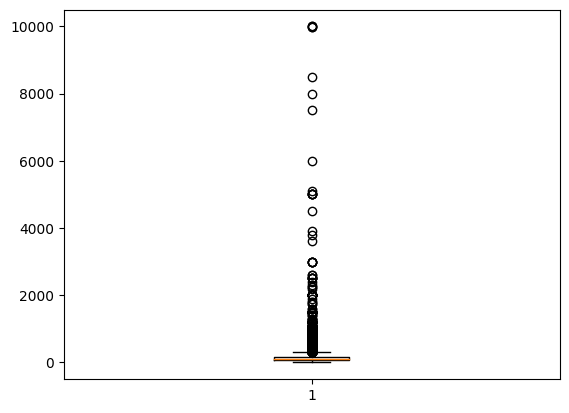

In [27]:
plt.boxplot(df_viz[['price']])
plt.show()

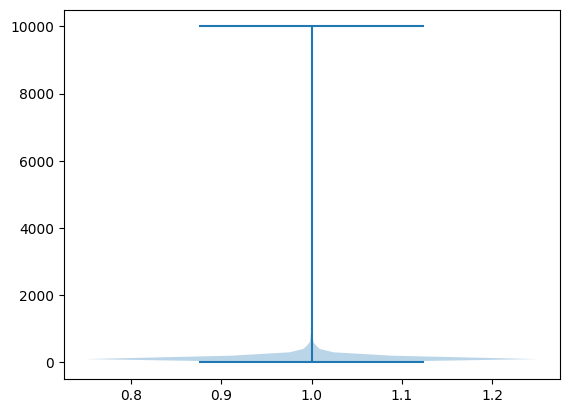

In [28]:
fig, ax = plt.subplots()
ax.violinplot(df_viz[['price']])
plt.show()

### 이상치 제거
-  price > 250 이상인 것은 제거한다.

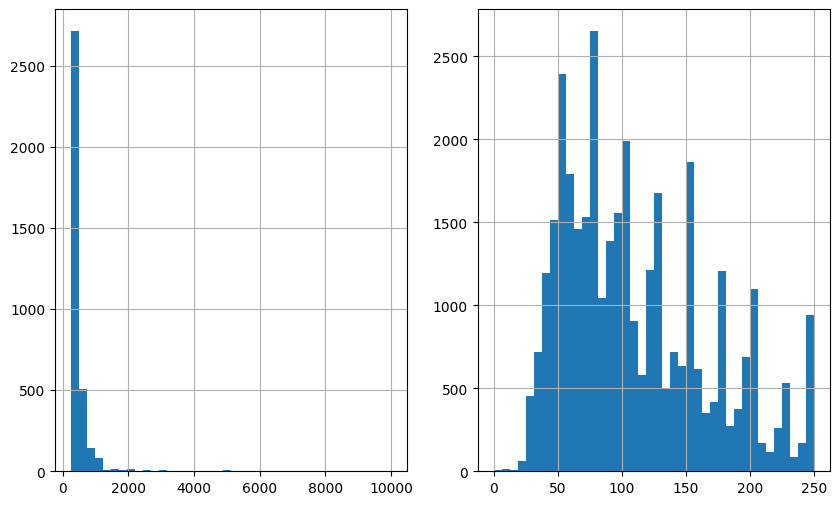

In [29]:
fig, ax = plt.subplots(ncols = 2, figsize=(10, 6))
df_viz[df_viz['price']>250].price.hist(bins=40, ax = ax[0])
df_viz[df_viz['price']<=250].price.hist(bins=40, ax = ax[1])
plt.show()

In [30]:
df2 = df2.filter(df2.price<=250)

- 제거된 데이터의 숫자는 약 3,520개이다.

In [31]:
df_viz[df_viz['price']>250].price.value_counts().sum()

3520

- 제거 후, 히스토그램은 다음과 같음

<Axes: >

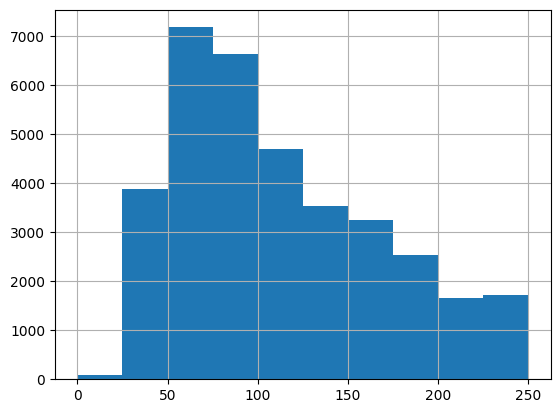

In [32]:
df_viz[df_viz['price']<=250].price.hist()

In [33]:
# 렌트비가 0원인것도 제외
df2 = df2.filter(df2.price!=0)

In [34]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string')]

## Pipelines 활용
- neighbourhood, room type and diff_in_days 컬럼 인코딩 변환

### Stringindexer & then one-hot encoding
- 문자열 컬럼 변환을 위해 StringIndexer를 사용한다.

In [35]:
# Sample data with a categorical column "category"
temp_data = [(0, "cat"), (1, "dog"), (2, "fish"), (3, "dog"), (4, "cat")]
temp_df = sc.createDataFrame(temp_data, ["id", "category"])
temp_df.show()

+---+--------+
| id|category|
+---+--------+
|  0|     cat|
|  1|     dog|
|  2|    fish|
|  3|     dog|
|  4|     cat|
+---+--------+



In [36]:
# Define the stages for the Pipeline
stringIndexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
encoder = OneHotEncoder(inputCol="categoryIndex", outputCol="categoryOneHot")

# Create a list of stages for the Pipeline
stages = [stringIndexer, encoder]

# Create a Pipeline with the defined stages
pipeline = Pipeline(stages=stages)

# Fit the pipeline to the data
model = pipeline.fit(temp_df)

# Transform the data using the fitted pipeline
transformed_df = model.transform(temp_df)

# Show the transformed data
transformed_df.show()

+---+--------+-------------+--------------+
| id|category|categoryIndex|categoryOneHot|
+---+--------+-------------+--------------+
|  0|     cat|          0.0| (2,[0],[1.0])|
|  1|     dog|          1.0| (2,[1],[1.0])|
|  2|    fish|          2.0|     (2,[],[])|
|  3|     dog|          1.0| (2,[1],[1.0])|
|  4|     cat|          0.0| (2,[0],[1.0])|
+---+--------+-------------+--------------+



- `StringIndexer` 는 각 카테고리에 고유한 인덱스를 할당하여 "카테고리" 열을 숫자 값으로 변환하는 데 사용됩니다. "categoryIndex"라는 새 열을 생성합니다.
- `OneHotEncoder`는 문자열 인덱서에서 생성된 숫자 인덱스를 원핫 인코딩된 벡터로 변환하는 데 사용됩니다. 이 인코더는 "categoryOneHot"이라는 이름의 새 열을 생성합니다.
- 정의된 StringIndexer 및 OneHotEncoder 스테이지가 포함된 stages, stages 목록을 생성합니다.
- pipeline 객체를 생성한다.
- pipeline 객체를 적용하여 DataFrame을 변환한 뒤, transform()을 적용한다.

In [37]:
ng_indexer = StringIndexer(inputCol="neighbourhood_group", outputCol="ng1")
n_indexer = StringIndexer(inputCol="neighbourhood", outputCol="n1")
rt_indexer = StringIndexer(inputCol="room_type", outputCol="rt1")
dfd_indexer = StringIndexer(inputCol="diff_in_days", outputCol="dfd1")

ng_onehot = OneHotEncoder(inputCol="ng1", outputCol="ngv")
n_onehot = OneHotEncoder(inputCol="n1", outputCol="nv")
rt_onehot = OneHotEncoder(inputCol="rt1", outputCol="rtv")
dfd_onehot = OneHotEncoder(inputCol="dfd1", outputCol="dfdv")

pipeline = Pipeline(stages=[ng_indexer, n_indexer, rt_indexer, dfd_indexer, \
                            ng_onehot, n_onehot, rt_onehot, dfd_onehot])
df3 = pipeline.fit(df2).transform(df2)
df3.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|ng1|  n1|rt1|dfd1|          ngv|              nv|          rtv|         dfdv|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|         

In [38]:
df3.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string'),
 ('ng1', 'double'),
 ('n1', 'double'),
 ('rt1', 'double'),
 ('dfd1', 'double'),
 ('ngv', 'vector'),
 ('nv', 'vector'),
 ('rtv', 'vector'),
 ('dfdv', 'vector')]

## Vectorizing features
- 여러 컬럼을 단일 특징 벡터 열로 합치기 위해 PySpark에서 VectorAssembler를 사용하는 방법을 보여준다.

In [39]:
va = VectorAssembler(inputCols = \
                     ['minimum_nights', 'number_of_reviews', 'reviews_per_month', \
                      'calculated_host_listings_count', 'availability_365', \
                      'ngv','rtv', 'nv', 'dfdv', 'latitude', 'longitude'], outputCol = 'features')
df4 = va.transform(df3)
df4.show()

+-------------------+------------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+--------------------+
|neighbourhood_group|     neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|ng1|  n1|rt1|dfd1|          ngv|              nv|          rtv|         dfdv|            features|
+-------------------+------------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+--------------------+
|           Brooklyn|        Kensington|   Private room|  149|             1|     

In [40]:
df4x = df4.select(['features', 'price'])
df4x.show(5)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(236,[0,1,2,3,4,5...|  149|
|(236,[0,1,2,3,4,6...|  225|
|(236,[0,1,2,3,4,5...|   89|
|(236,[0,1,2,3,6,1...|   80|
|(236,[0,1,2,3,4,6...|  200|
+--------------------+-----+
only showing top 5 rows



### MinMax Scaler
- 수치 데이터를 모두 MinMax Scaler로 변환한다.

In [41]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(df4x)
df4 = scalerModel.transform(df4x)
df4.show(5)

+--------------------+-----+--------------------+
|            features|price|      scaledFeatures|
+--------------------+-----+--------------------+
|(236,[0,1,2,3,4,5...|  149|(236,[1,2,3,4,5,9...|
|(236,[0,1,2,3,4,6...|  225|(236,[1,2,3,4,6,1...|
|(236,[0,1,2,3,4,5...|   89|(236,[1,2,4,5,10,...|
|(236,[0,1,2,3,6,1...|   80|(236,[0,1,2,6,10,...|
|(236,[0,1,2,3,4,6...|  200|(236,[0,1,2,4,6,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



- 최종적인 컬럼을 위해 적절하게 컬럼명을 변경한다.

In [42]:
df4 = df4.select('scaledFeatures', 'price')
df4 = df4.withColumnRenamed("scaledFeatures","features")
df4 = df4.withColumnRenamed("price","label")
df4.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(236,[1,2,3,4,5,9...|  149|
|(236,[1,2,3,4,6,1...|  225|
+--------------------+-----+
only showing top 2 rows



## 데이터 내보내기
- 1차 가공을 완료하면 데이터를 외부에 저장하도록 한다.

In [43]:
df4.repartition(1).write.parquet(DATA_PATH + "saved_231025.parquet")

## 데이터 다시 불러오기

In [44]:
df5 = sc.read.load(DATA_PATH + "saved_231025.parquet")
df5.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(236,[1,2,3,4,5,9...|  149|
|(236,[1,2,3,4,6,1...|  225|
|(236,[1,2,4,5,10,...|   89|
|(236,[0,1,2,6,10,...|   80|
|(236,[0,1,2,4,6,1...|  200|
+--------------------+-----+
only showing top 5 rows



## Train-Test split
- 훈련 데이터와 테스트 데이터로 분리한다.

In [45]:
splits = df4.randomSplit([0.7, 0.3], seed=12345)
train_df = splits[0]
test_df = splits[1]

# Linear Regression without Feature Engineering

In [46]:
df3_raw = df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', \
               'minimum_nights','number_of_reviews', 'reviews_per_month', \
               'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude')

df3_raw = df3_raw.na.drop("any")

df3_raw = df3_raw.withColumn("price", df3_raw["price"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("minimum_nights", df3_raw["minimum_nights"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("number_of_reviews", df3_raw["number_of_reviews"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("reviews_per_month", df3_raw["reviews_per_month"].cast(FloatType()))
df3_raw = df3_raw.withColumn("calculated_host_listings_count", df3_raw["calculated_host_listings_count"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("availability_365", df3_raw["availability_365"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("latitude", df3_raw["latitude"].cast(FloatType()))
df3_raw = df3_raw.withColumn("longitude", df3_raw["longitude"].cast(FloatType()))


df3_raw = df3_raw.na.drop("any")

pipeline = Pipeline(stages=[ng_indexer, n_indexer, rt_indexer, \
                            ng_onehot, n_onehot, rt_onehot])
df4_raw = pipeline.fit(df3_raw).transform(df3_raw)

va1 = VectorAssembler(inputCols = \
                     ['minimum_nights', 'number_of_reviews', 'reviews_per_month', \
                        'calculated_host_listings_count', 'availability_365', \
                      'ngv','rtv', 'nv', 'latitude', 'longitude'], outputCol = 'features')

df5_raw = va1.transform(df4_raw)
df5x_raw = df5_raw.select(['features', 'price'])

splits_raw = df5x_raw.randomSplit([0.7, 0.3], seed=12345)
train_df_raw = splits_raw[0]
test_df_raw = splits_raw[1]
#print(train_df_raw.collect()[5])

lr_raw = LinearRegression(featuresCol = 'features', labelCol='price')
lr_model_raw = lr_raw.fit(train_df_raw)
fullPredictions_raw = lr_model_raw.transform(test_df_raw).cache()
lr_evaluator_raw = RegressionEvaluator(predictionCol="prediction", labelCol="price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_raw.evaluate(fullPredictions_raw))
lr_evaluator_raw = RegressionEvaluator(predictionCol="prediction", labelCol="price",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator_raw.evaluate(fullPredictions_raw))

R Squared (R2) on test data = 0.141252
RMSE (R2) on test data = 184.995


# Linear Regression on Feature Engineered data

In [47]:
lr = LinearRegression(featuresCol = 'features', labelCol='label')
lr_model = lr.fit(train_df)
#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))

In [48]:
trainingSummary = lr_model.summary
print("Linear Regression RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Linear Regression R2: %f" % trainingSummary.r2)

Linear Regression RMSE: 37.193762
Linear Regression R2: 0.564775


In [49]:
# TEST Results
fullPredictions = lr_model.transform(test_df).cache()
print(fullPredictions)
fullPredictions.select("prediction","label","features").show(5)

DataFrame[features: vector, label: int, prediction: double]
+-----------------+-----+--------------------+
|       prediction|label|            features|
+-----------------+-----+--------------------+
|66.27420250247772|   70|(236,[0,1,2,3,4,5...|
|82.27083455913379|   49|(236,[0,1,2,3,4,5...|
|62.06087881951285|   65|(236,[0,1,2,3,4,5...|
|84.09239291832705|   43|(236,[0,1,2,3,4,5...|
| 77.8318133320393|   55|(236,[0,1,2,3,4,5...|
+-----------------+-----+--------------------+
only showing top 5 rows



In [50]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(fullPredictions))
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator.evaluate(fullPredictions))
rmse = lr_evaluator.evaluate(fullPredictions)

R Squared (R2) on test data = 0.563509
RMSE (R2) on test data = 36.9113


In [51]:
"%2f"%rmse

'36.911281'

In [52]:
"{:.2f}".format(rmse)

'36.91'

# Linear Regression using HyperParameter Tuning

In [53]:
train, test = df4.randomSplit([0.7, 0.3], seed=2)

lr = LinearRegression(maxIter=10)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.7)

model = tvs.fit(train)

preds = model.transform(test)\
    .select("features", "label", "prediction")

R Squared (R2) on test data = 0.561017
RMSE (R2) on test data = 37.1934


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(preds))
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator.evaluate(preds))

# Decision Tree Regressor

In [54]:
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='label')
dt_model = dt.fit(train_df)
dtPrediction = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dtPrediction))
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dtPrediction))

R Squared (R2) on test data = 0.543221
RMSE on test data = 37.7593


In [55]:
dtPrediction.show(5)

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|(236,[0,1,2,3,4,5...|   70|65.46760391198045|
|(236,[0,1,2,3,4,5...|   49|65.46760391198045|
|(236,[0,1,2,3,4,5...|   65|65.46760391198045|
|(236,[0,1,2,3,4,5...|   43|65.46760391198045|
|(236,[0,1,2,3,4,5...|   55|65.46760391198045|
+--------------------+-----+-----------------+
only showing top 5 rows

